# Time-Series Analysis of Microsoft Stock Prices

In this notebook I explore time series forecasting techniques on Microsoft's historical stock prices, obtained from kaggle (https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis). The dataset includes daily open, high, low, close, and volume data. In this analysis I focus on predicting closing price. I experiment with multiple forecasting models and evaluate them using MAPE on a holdout set. Using the best model, a forecast can be made into the actual future.

## Exploratory Data Analysis

In [1]:
import kagglehub
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

path = kagglehub.dataset_download("vijayvvenkitesh/microsoft-stock-time-series-analysis")

csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

csv_path = os.path.join(path, csv_files[0])
df = pd.read_csv(csv_path)
display(df.head())

df.info()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [2]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y %H:%M:%S")
print(df.dtypes)
df.set_index("Date", inplace=True)
display(df.head())

df_original = df.copy()

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


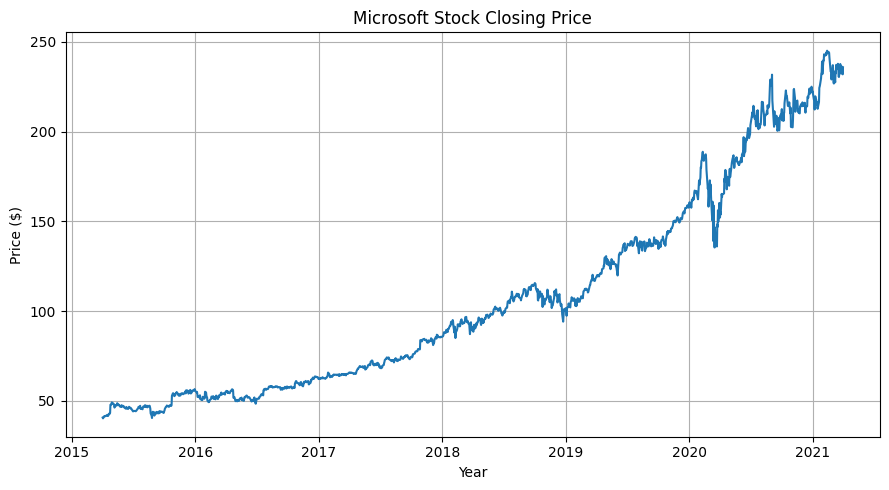

In [3]:
import matplotlib.pyplot as plt


def run_plot(df, column, title=None, ylabel=None):
    """
    Plot a time series column from a DataFrame using the index as x-axis.

    Assumes the index is datetime (e.g. 'Date').
    """
    plt.figure(figsize=(9, 5))
    plt.plot(df.index, df[column])
    plt.title(title or f"Run Plot of {column}")
    plt.xlabel("Year")
    plt.ylabel(ylabel or column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
run_plot(df, "Close", title="Microsoft Stock Closing Price", ylabel="Price ($)")

### Remarks
In this stock a clear upwards trend can be observed. Given that we're dealing with stock data it's also reasonable to assume a seasonal component, which will be investigated. Excluding holidays and weekends, there are approximately 252 operational days in a year. Another notable observating is a clear market crash right around the Covid Pandemic (March 2020). In the next part of this exploratory analysis I'll try to break down the time-series and decompose it to obtain a stationary series.

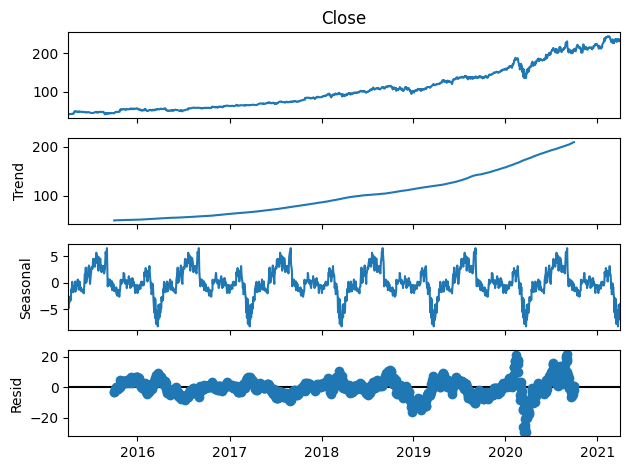

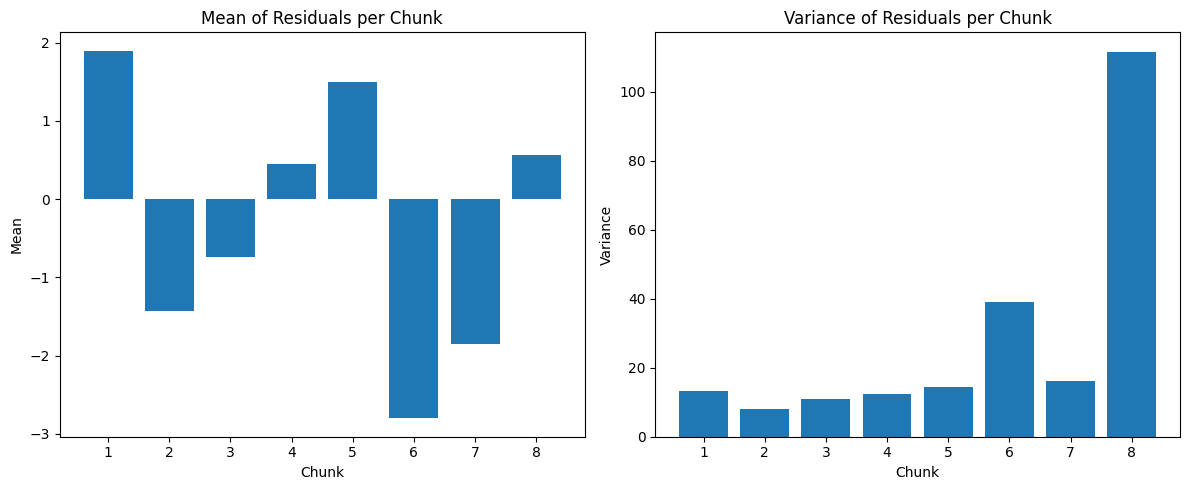


ADF Test on Close Price
-----------------------
Test Statistic             1.737136
p-value                    0.998216
Lags Used                 24.000000
Observations Used       1486.000000
Critical Value (1%)       -3.434758
Critical Value (5%)       -2.863487
Critical Value (10%)      -2.567807
dtype: float64


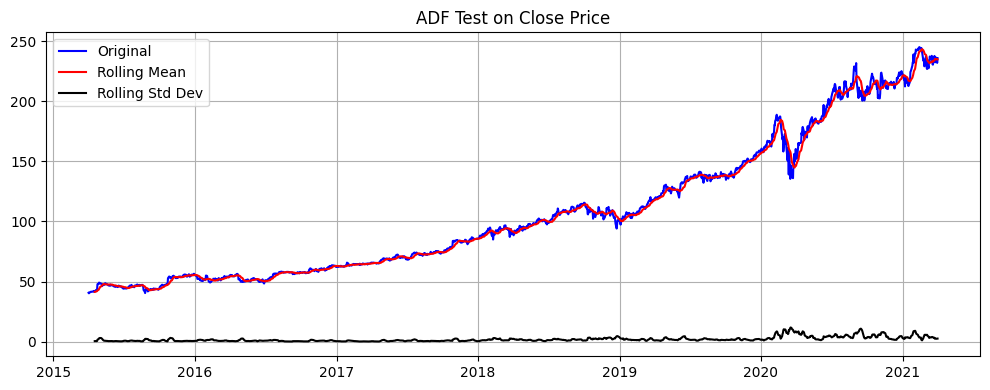

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np

result = seasonal_decompose(df["Close"], model="additive", period=252)  # 252 = trading days/year
result.plot()
plt.tight_layout()
plt.show()

residuals = result.resid

def residual_chunk_stats(residuals, n_chunks=10):
    """
    Divide residuals into `n_chunks` and compute mean and variance per chunk.
    
    Returns:
    - List of means
    - List of variances
    - List of index ranges for plotting
    """
    residuals = residuals.values
    chunk_size = len(residuals) // n_chunks

    mus, variances, ranges = [], [], []

    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_chunks - 1 else len(residuals)
        chunk = residuals[start:end]

        mu = np.mean(chunk)
        var = np.var(chunk)
        
        mus.append(mu)
        variances.append(var)
        ranges.append((start, end))

    return mus, variances, ranges

def plot_chunk_stats(mus, variances, n_chunks):
    x = np.arange(n_chunks)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(x, mus)
    plt.title("Mean of Residuals per Chunk")
    plt.xlabel("Chunk")
    plt.ylabel("Mean")

    plt.subplot(1, 2, 2)
    plt.bar(x, variances)
    plt.title("Variance of Residuals per Chunk")
    plt.xlabel("Chunk")
    plt.ylabel("Variance")

    plt.tight_layout()
    plt.show()
    
    
def dftest(timeseries, title="ADF Test and Rolling Statistics"):
    timeseries = timeseries.dropna()  # Ensure no NaNs

    # Perform ADF test
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    
    print(f"\n{title}")
    print("-" * len(title))
    print(dfoutput)

    # Rolling stats
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std Dev')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
mus, vars, _ = residual_chunk_stats(result.resid, n_chunks=10)
plot_chunk_stats(mus, vars, n_chunks=10)
dftest(df["Close"], title="ADF Test on Close Price")


#### Remarks
From the decomposition it is clear that we are dealing with a trend as well as a seasonal component. Using a Moving Average smoothing technique, it becomes clear that there is still some preiodicity left in the residuals, since the rolling mean, i.e. local average, changes. The variance also changes with a higher variance appearing for the last chunck of data, demonstrating heteroscedasticity, likely due to the COVID pandemic. The ADF-test with a p-value of almost 1, further supports the claim that the current residuals are not a stationary time-series. Some transformation techniques can be applied to further smooth out the data, with the goal of obtaining a stationary time-series. 


## Preprocessing

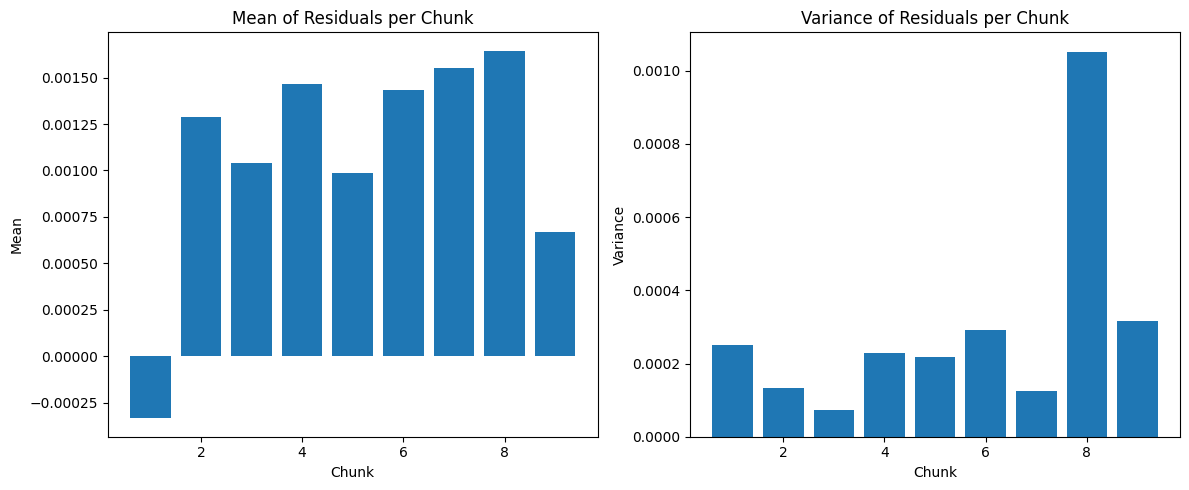


ADF Test on Log-Differenced Close Price
---------------------------------------
Test Statistic         -1.380108e+01
p-value                 8.569245e-26
Lags Used               8.000000e+00
Observations Used       1.501000e+03
Critical Value (1%)    -3.434714e+00
Critical Value (5%)    -2.863467e+00
Critical Value (10%)   -2.567796e+00
dtype: float64


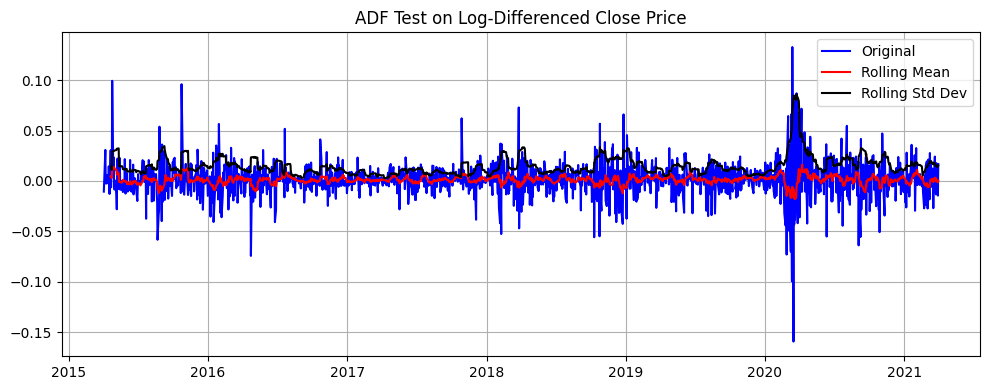

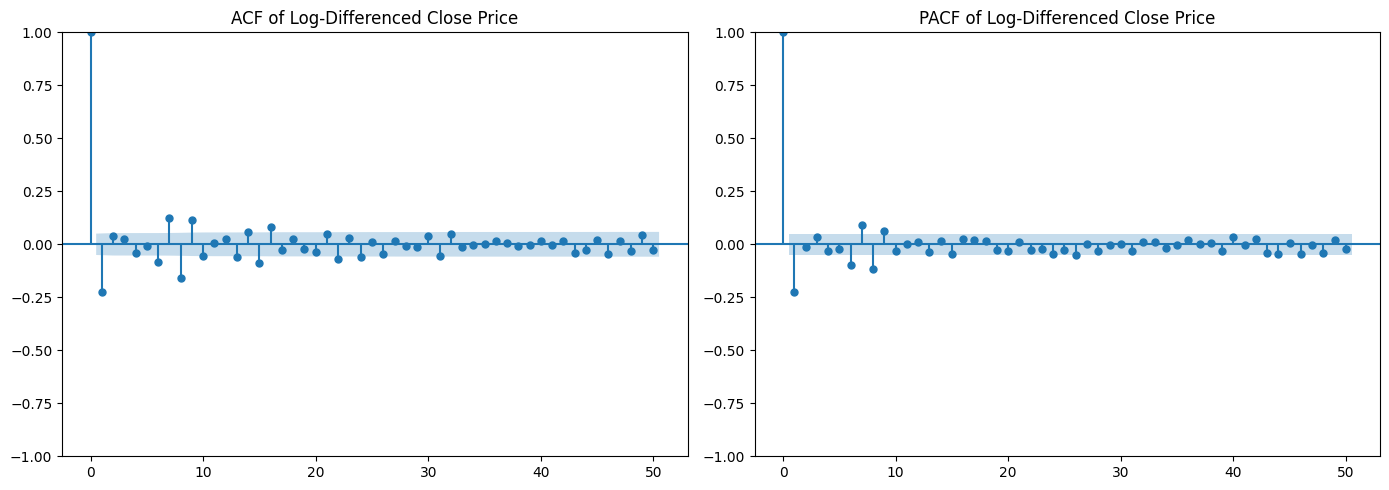

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df["LogClose"] = np.log(df["Close"])
df["LogClose_diff"] = df["LogClose"].diff()

mus, vars, _ = residual_chunk_stats(df["LogClose_diff"], n_chunks=10)
plot_chunk_stats(mus, vars, n_chunks=10)
dftest(df["LogClose_diff"], title="ADF Test on Log-Differenced Close Price")



fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df["LogClose_diff"].dropna(), lags=50, ax=axes[0])
axes[0].set_title("ACF of Log-Differenced Close Price")

plot_pacf(df["LogClose_diff"].dropna(), lags=50, ax=axes[1])
axes[1].set_title("PACF of Log-Differenced Close Price")

plt.tight_layout()
plt.show()

#### Remarks

First I apply a log transformation to counter heteroscedasticity. Then I apply differencing (taking the value at the current time point, and subtracting the value of the previous time point), to account for any left-over trend in the residuals. After applying this and performing the same diagnostics as before, the residuals seem stationary. To summarize why these findings show a stationary time-series for these residuals: the mean and variance of the moving average stay quite constant; ADF test with p-value close to zero strongly hints at it; visually the run plot looks like random noise. The ACF and PACF plots of the log-differenced close price show a significant spike at lag 1 in both plots — positive in ACF and negative in PACF — indicating short-term autocorrelation but no persistent long-range memory. This supports the use of low-order ARMA or ARIMA models for modeling the stationary transformed series.

## Modeling and forecasting

In this section I will explore various models to forecast close price on a holdout set, to predict the price of the last period, while also being able to evaluate it. The evaluation metric used to compare these models will be the Mean Absolute Percentage Error (MAPE), defined as

MAPE = $\frac{1}{n} \sum_{t=1}^{n} \left| \frac{y_{t} - \hat{y}_{t}}{y_{t}} \right|$

with close price $y_{t}$, and prediction $\hat{y}_{t}$, at time $t$. This metric is chosen since it takes into account relative errors as opposed to mean squared error, which will give different orders of magnitude depending on whether the data is transformed or not, making comparison between untransformed and transformed, difficult.

The models will be compared and the one that yields the best prediction will be used for actual forecasting into the future, i.e. beyond the holdout set.

### Triple Exponential Smoothing
Before using advanced time-series models, I'll start with the simplest appropriate one, which is triple exponential smoothing. This takes into account trend + seasonality. This will be performed on the non stationary data, i.e. the original which contain trend and seasonality. Since I identified what kind of series and relevant factors we're dealing with, I'll allow the smoothing technique to take these into account.

Holt-Winters MAPE on holdout: 4.56%


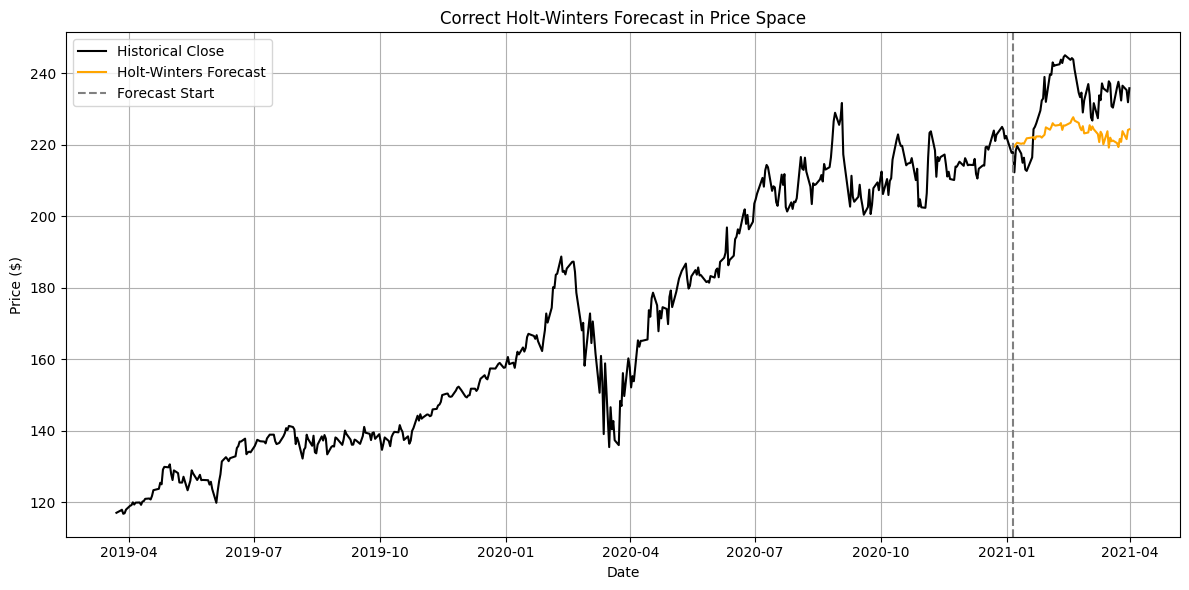

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

n_holdout = 60 
series = df["Close"]

train = series[:-n_holdout]
test = series[-n_holdout:]

def mape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Avoid division by zero
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask]))


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hw_model = ExponentialSmoothing(
        train,
        trend="add",
        seasonal="add",
        seasonal_periods=252
    ).fit()

    hw_forecast = hw_model.forecast(n_holdout)

hw_forecast.index = test.index

# Evaluate MAPE
mape_hw = mape(test, hw_forecast)
print(f"Holt-Winters MAPE on holdout: {mape_hw:.2%}")

forecast_index = test.index
hw_forecast.index = forecast_index

plt.figure(figsize=(12, 6))
plt.plot(series[1000:], label="Historical Close", color="black")
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters Forecast", color="Orange")
# plt.plot(test.index, test, label="Actual (Holdout)", color="green", linestyle="dashed")
plt.axvline(hw_forecast.index[0], color="gray", linestyle="--", label="Forecast Start")
plt.title("Correct Holt-Winters Forecast in Price Space")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Remarks
With a MAPE of only 4.56%, triple exponential smoothing does well at forecasting this data. However, looking at the runplot, we can see how there seems to be a bit of a lag, and the model is not picking up on the rapidly growing trend. It also possibly overfits to noise rather than capturing this trend. Perhaps more advanced models will do better.

### ARMA model
For the ARMA I'll use the transformed residuals (stationary) that was constructed before, as stationarity is a requirement for the ARMA model. Since I applied differencing one time this is equal to ARIMA with differencing order $i=1$. Judging by the earlier conclusion of the ACF and PACF plot a lower order ARMA with $(p,q)=(1,1)$ should be sufficient.

                               SARIMAX Results                                
Dep. Variable:          LogClose_diff   No. Observations:                 1450
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3847.565
Date:                Mon, 21 Apr 2025   AIC                          -7687.129
Time:                        16:02:05   BIC                          -7666.012
Sample:                             0   HQIC                         -7679.249
                               - 1450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.084      0.002       0.000       0.002
ar.L1         -0.1930      0.059     -3.269      0.001      -0.309      -0.077
ma.L1         -0.0347      0.064     -0.546      0.5

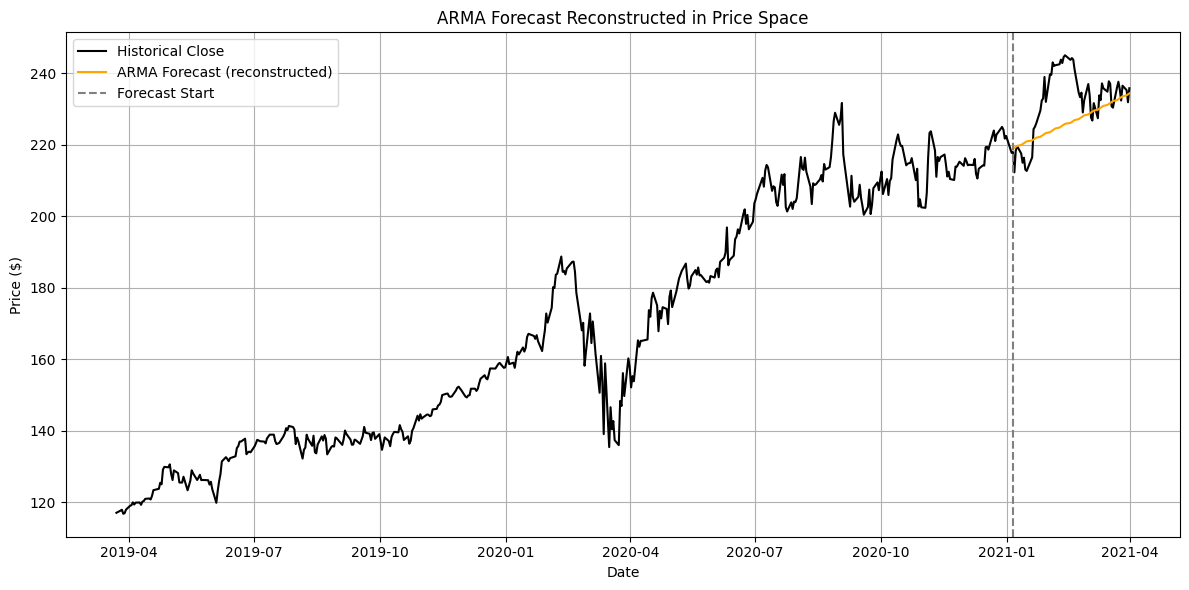

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

series = df["LogClose_diff"].dropna()

train = series[:-n_holdout]
test = series[-n_holdout:]

# Fit ARMA(2, 2) (i.e., ARIMA with d=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arma_model = ARIMA(train, order=(1, 0, 1))
    arma_result = arma_model.fit()
    print(arma_result.summary())
    
    forecast = arma_result.forecast(steps=n_holdout)

# Reconstruct actual prices as before
last_log_value = df["LogClose"].iloc[-n_holdout - 1]
true_log_prices = np.r_[last_log_value, test.values].cumsum()[1:]
true_prices = np.exp(true_log_prices)



# Get last known log price (before forecast starts)
last_log_value = df["LogClose"].iloc[-n_holdout - 1]

# Reconstruct log-prices by cumulatively summing diffs
log_forecast = np.r_[last_log_value, forecast].cumsum()[1:]

# Convert back to actual price
price_forecast = np.exp(log_forecast)

# Use the forecast you've already constructed
mape_arma = mape(true_prices, price_forecast)
print(f"ARMA MAPE on holdout: {mape_arma:.2%}")


# Full historical Close
actual = df["Close"][1000:]

# Plot full series + prediction
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Historical Close", color="black")
plt.plot(forecast_index, price_forecast, label="ARMA Forecast (reconstructed)", color="orange")
plt.axvline(forecast_index[0], color="gray", linestyle="--", label="Forecast Start")
plt.title("ARMA Forecast Reconstructed in Price Space")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Remarks
The ARMA(1,1) model has a MAPE of 3.19%, which is an improvement w.r.t. of Triple Exponential Smoothing. Visually, the forecast seems to capture the upward trend. Next SARIMA will be used to see if the prediction can be improved even more.

### SARIMA model
The SARIMA model which is just a seasonal version of ARIMA, does a good job at capturing seasonality, therefore the passed series does not need to have this seasonality. I'll pass the original data, but still use the log-transformation as heteroscedasticity, could negatively impact the models accuracy.

                                      SARIMAX Results                                       
Dep. Variable:                             LogClose   No. Observations:                 1451
Model:             SARIMAX(2, 2, 2)x(0, 1, [1], 30)   Log Likelihood                3639.389
Date:                              Mon, 21 Apr 2025   AIC                          -7266.779
Time:                                      16:04:10   BIC                          -7235.373
Sample:                                           0   HQIC                         -7255.033
                                             - 1451                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1238      0.032    -35.178      0.000      -1.186      -1.061
ar.L2         -0.24

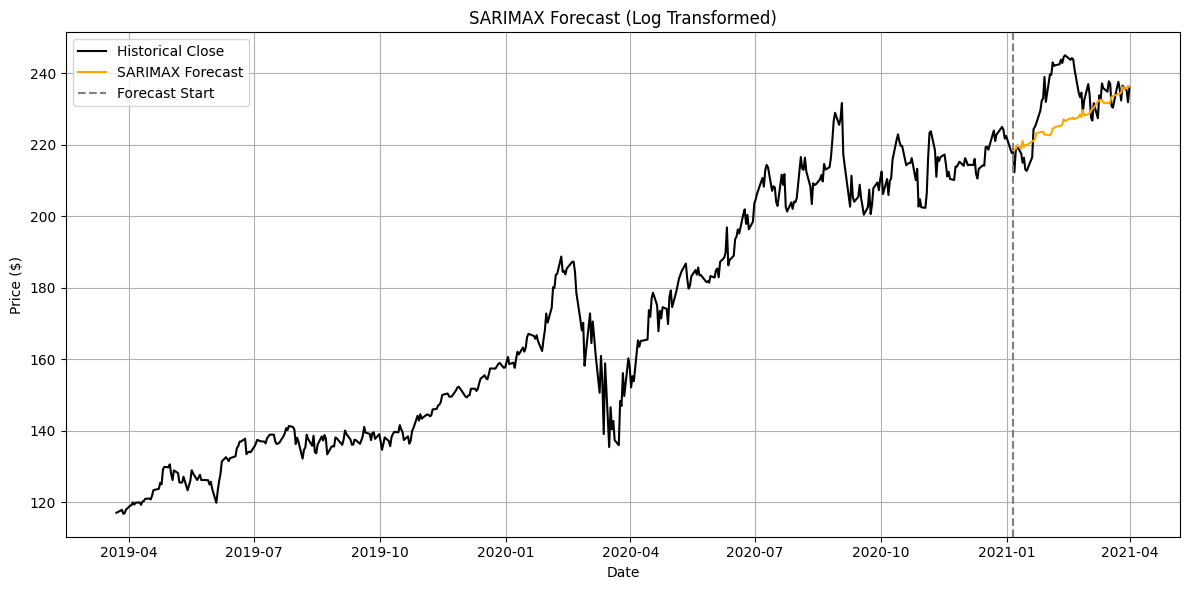

In [23]:
series = df["LogClose"].dropna()
train = series[:-n_holdout]
test = series[-n_holdout:]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_model = SARIMAX(
        train,
        order=(2, 2, 2),
        seasonal_order=(0, 1, 1, 30),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarimax_result = sarimax_model.fit(disp=False)
    print(sarimax_result.summary())

    
    forecast_log = sarimax_result.get_forecast(steps=n_holdout).predicted_mean

forecast_index = test.index
forecast_log.index = forecast_index
forecast_prices = np.exp(forecast_log)

true_prices = df["Close"].loc[forecast_index]
sarimax_mape = np.mean(np.abs((true_prices - forecast_prices) / true_prices))
print(f"SARIMAX MAPE on holdout: {sarimax_mape:.2%}")


plt.figure(figsize=(12, 6))
plt.plot(df["Close"][1000:], label="Historical Close", color="black")
plt.plot(forecast_index, forecast_prices, label="SARIMAX Forecast", color="orange")
plt.axvline(forecast_index[0], color="gray", linestyle="--", label="Forecast Start")
plt.title("SARIMAX Forecast (Log Transformed)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Remarks
SARIMA with a MAPE of 3.01% yields another improvement. Running this especially with increased seasonal component (that's why I did not pick $s=252$) proves to be computationally expensive. 

### Facebook Prophet forecasting
The last model I'll use will be Facebook's Prophet forecasting tool. A benefit of Prophet is, that it includes automatic seasonality detection, instead of passing it as a hyperparameter, which proved to be intensive for the SARIMA model. Aside from this, Prophet is designed to be accurate, interpretable, and robust to outliers and missing data. It works well with business time series like stock prices

16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE on holdout: 2.54%


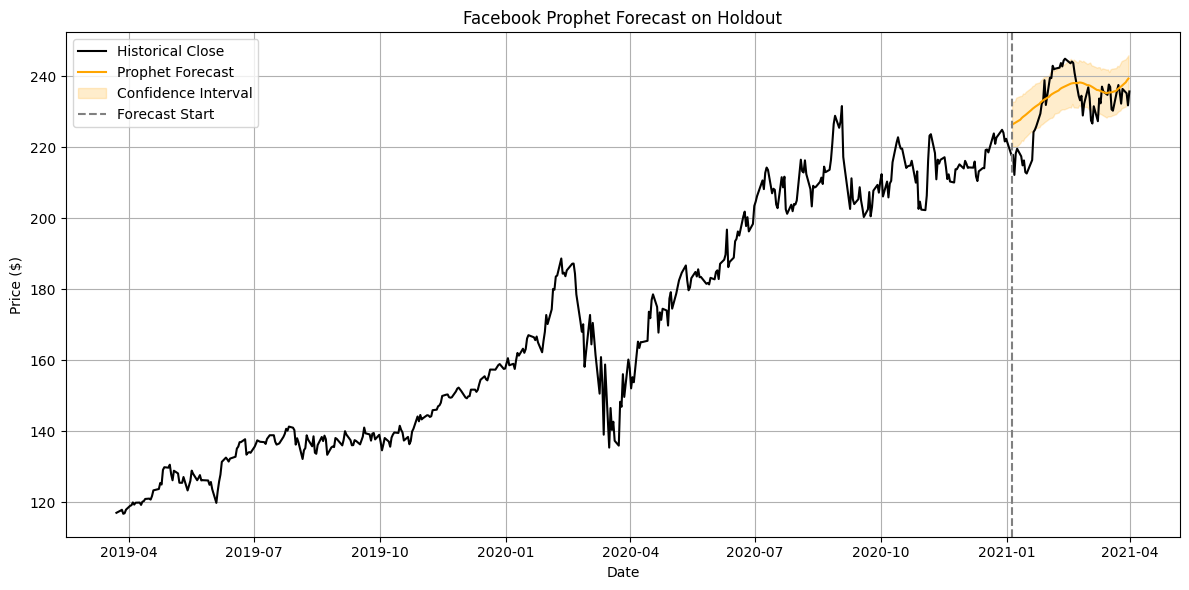

In [25]:
from prophet import Prophet

# Create Prophet-style DataFrame
df_prophet = df.reset_index()[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"]).dt.normalize()  # remove time

train_df = df_prophet[:-n_holdout]
test_df = df_prophet[-n_holdout:]

model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(train_df)

future = pd.DataFrame({"ds": test_df["ds"]})
forecast = model.predict(future)

forecast["ds"] = pd.to_datetime(forecast["ds"]).dt.normalize()
forecast_holdout = forecast.set_index("ds").loc[test_df["ds"]]

first_test_actual = test_df["y"].iloc[0]
first_forecast = forecast_holdout["yhat"].iloc[0]
offset = first_test_actual - first_forecast

mape_prophet = mape(test_df["y"], forecast_holdout["yhat"].values)
print(f"Prophet MAPE on holdout: {mape_prophet:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(df["Close"][1000:], label="Historical Close", color="black")
plt.plot(forecast_holdout.index, forecast_holdout["yhat"], label="Prophet Forecast", color="orange")
plt.fill_between(
    forecast_holdout.index,
    forecast_holdout["yhat_lower"],
    forecast_holdout["yhat_upper"],
    color="orange",
    alpha=0.2,
    label="Confidence Interval"
)
plt.axvline(test_df["ds"].iloc[0], color="gray", linestyle="--", label="Forecast Start")
plt.title("Facebook Prophet Forecast on Holdout")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Remarks
Prohet is quickly able to obtain the best MAPE yet on the holdout of 2.54%. It also shows confidence interval (default 95%), and visually, clearly captures most of the actual close price.

## Actual forecast using Facebook Prophet
Since Prophet proved to be the most robust, it will now be used to try and make the most accurate forecast into the actual future (w.r.t. the dataset end-date). Another unmentioned benefit of Prophet is that it can take into account change-points as a parameter, such as the COVID pandemic, which had a clear effect on the market

15:04:01 - cmdstanpy - INFO - Chain [1] start processing
15:04:01 - cmdstanpy - INFO - Chain [1] done processing


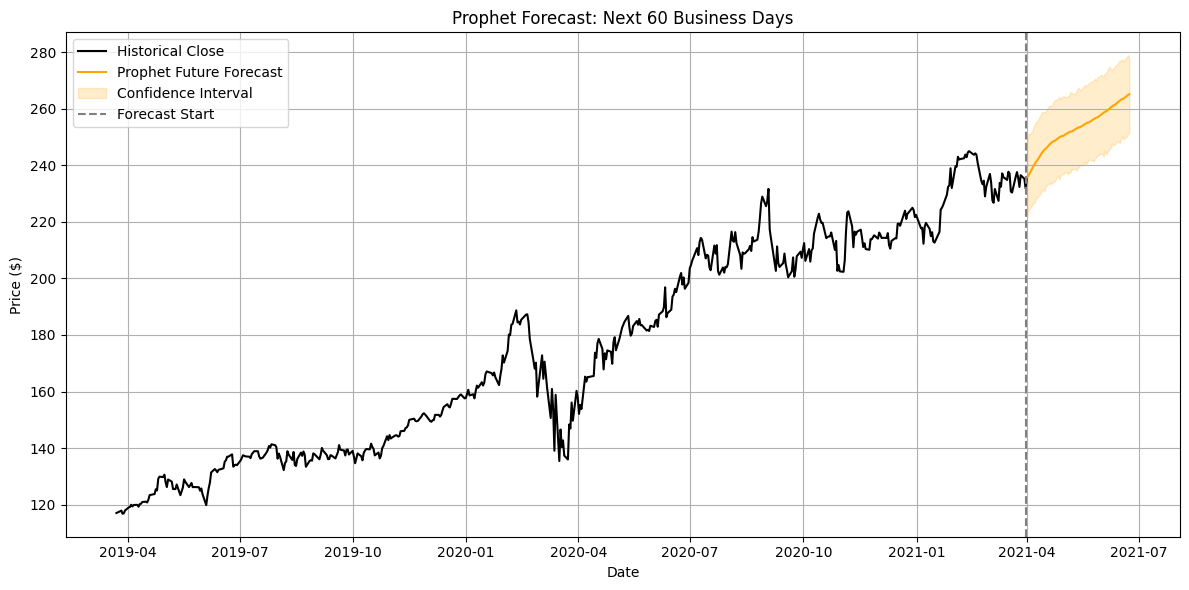

In [16]:
covid_changepoints = ["2020-03-16"]

# Fit Prophet with manual changepoint
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    changepoints=covid_changepoints
)
model.fit(df_prophet)

n_future = 60
future = model.make_future_dataframe(periods=n_future, freq='B')  # 'B' = business day frequency
forecast = model.predict(future)

last_date = df_prophet["ds"].max()
future_forecast = forecast[forecast["ds"] > last_date]

last_actual = df["Close"].iloc[-1]
first_forecast = future_forecast["yhat"].iloc[0]
offset = last_actual - first_forecast

future_forecast["yhat"] += offset
future_forecast["yhat_lower"] += offset
future_forecast["yhat_upper"] += offset

plt.figure(figsize=(12, 6))
plt.plot(df["Close"][1000:], label="Historical Close", color="black")
plt.plot(future_forecast["ds"], future_forecast["yhat"], label="Prophet Future Forecast", color="orange")
plt.fill_between(
    future_forecast["ds"],
    future_forecast["yhat_lower"],
    future_forecast["yhat_upper"],
    color="orange",
    alpha=0.2,
    label="Confidence Interval"
)
plt.axvline(x=last_date, color="gray", linestyle="--", label="Forecast Start")
plt.title(f"Prophet Forecast: Next {n_future} Business Days")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Remarks
After identifying the offset, the starting prediction can be set equal to the last data point to not have a discontinuous prediction. The predicted future close price, seems to be following the ongoing rising trend well.

# By Noah Knijff (2025)